In [1]:
import matplotlib
matplotlib.use("AGG")
from matplotlib import pyplot


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from collections import Counter

In [3]:
import numpy as np
path = 'drive/MyDrive/handwrittengen/data/'
with open(path+'sentences.txt', 'r') as f:
    texts = f.read().splitlines()

strokes = np.load(path+'strokes.npy', allow_pickle=True,encoding='bytes')
print(len(texts), len(strokes))


6000 6000


In [4]:

def plot_stroke(stroke, save_name=None):
    # Plot a single example.
    f, ax = pyplot.subplots()

    x = np.cumsum(stroke[:, 1])
    y = np.cumsum(stroke[:, 2])

    size_x = x.max() - x.min() + 1.0
    size_y = y.max() - y.min() + 1.0

    f.set_size_inches(5.0 * size_x / size_y, 5.0)

    cuts = np.where(stroke[:, 0] == 1)[0]
    start = 0

    for cut_value in cuts:
        ax.plot(x[start:cut_value], y[start:cut_value], "k-", linewidth=3)
        start = cut_value + 1

    ax.axis("off")  # equal
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if save_name is None:
        pyplot.show()
    else:
        try:
            pyplot.savefig(save_name, bbox_inches="tight", pad_inches=0.5)
        except Exception:
            print("Error building image!: " + save_name)

        pyplot.close()

In [5]:
print(strokes[1])

[[ 0.    0.    0.  ]
 [ 0.    0.15 -0.25]
 [ 0.    0.25 -0.1 ]
 ...
 [ 0.    1.65 -0.05]
 [ 0.    2.    0.2 ]
 [ 1.    2.05  0.6 ]]


In [6]:
plot_stroke(strokes[1],'s1.png')

In [7]:

def train_offset_normalization(data):
    """
       The co-ordinate offsets are normalised to
       mean 0, std. dev. 1 over the training set.
    """
    mean = data[:, :, 1:].mean(axis=(0, 1))
    data[:, :, 1:] -= mean
    std = data[:, :, 1:].std(axis=(0, 1))
    data[:, :, 1:] /= std

    return mean, std, data


def valid_offset_normalization(mean, std, data):
    """
       Data normalization using train set mean and std
    """
    data[:, :, 1:] -= mean
    data[:, :, 1:] /= std
    return data


def data_denormalization(mean, std, data):
    """
       Data denormalization using train set mean and std
    """
    data[:, :, 1:] *= std
    data[:, :, 1:] += mean

    return data


def data_normalization(data):
    """
       Data denormalization using train set mean and std
    """
    mean = data[:, 1:].mean(axis=0)
    data[:, 1:] -= mean
    std = data[:, 1:].std(axis=0)
    data[:, 1:] /= std

    return mean, std, data


def data_processing(data):
    """
       Data denormalization using train set mean and std
    """
    min_xy = data[:, 1:].min(axis=0)
    data[:, 1:] -= min_xy
    max_xy = data[:, 1:].max(axis=0)
    data[:, 1:] /= (max_xy - min_xy)
    data[:, 1:] *= 10
    return data

In [8]:
class Global:
    train_mean = 0.0
    train_std = 1.0

In [9]:
class HandwritingDataset(Dataset):
    """Handwriting dataset."""

    def __init__(self, data_path, split='train', text_req=False, debug=False, max_seq_len=300, data_aug=False):
        """
        Args:
            data_path (string): Path to the data folder.
            split (string): train or valid
        """
        self.text_req = text_req
        self.max_seq_len = max_seq_len
        self.data_aug = data_aug

        strokes = np.load(data_path + 'strokes.npy', allow_pickle=True, encoding='bytes')
        with open(data_path + 'sentences.txt','r') as file:
            texts = file.read().splitlines()

        # list of length of each stroke in strokes
        lengths = [len(stroke) for stroke in strokes]
        max_len = np.max(lengths)
        n_total = len(strokes)

        # Mask
        mask_shape = (n_total, max_len)
        mask = np.zeros(mask_shape, dtype=np.float32)

        # Convert list of str into array of list of chars
        char_seqs = [list(char_seq) for char_seq in texts]
        #char_seqs = np.asarray(char_seqs)

        char_lens = [len(char_seq) for char_seq in char_seqs]
        max_char_len = np.max(char_lens)

        # char Mask
        mask_shape = (n_total, max_char_len)  # (6000,64)
        char_mask = np.zeros(mask_shape, dtype=np.float32)

        # Input text array
        inp_text = np.ndarray((n_total, max_char_len), dtype='<U1')
        inp_text[:, :] = ' '

        # Convert list of stroke(array) into ndarray of size(n_total, max_len, 3)
        data_shape = (n_total, max_len, 3)
        data = np.zeros(data_shape, dtype=np.float32)

        for i, (seq_len, text_len) in enumerate(zip(lengths, char_lens)):
            mask[i, :seq_len] = 1.
            data[i, :seq_len] = strokes[i]
            char_mask[i, :text_len] = 1.
            inp_text[i, :text_len] = char_seqs[i]

        # create vocab
        self.id_to_char, self.char_to_id = self.build_vocab(inp_text)
        self.vocab_size = len(self.id_to_char)

        idx_permute = np.random.permutation(n_total)
        data = data[idx_permute]
        mask = mask[idx_permute]
        inp_text = inp_text[idx_permute]
        char_mask = char_mask[idx_permute]

        if debug:
            data = data[:64]
            mask = mask[:64]
            inp_text = inp_text[:64]
            char_mask = char_mask[:64]

        n_train = int(0.9 * data.shape[0])
        self._data = data
        if split == 'train':
            self.dataset = data[:n_train]
            self.mask = mask[:n_train]
            self.texts = inp_text[:n_train]
            self.char_mask = char_mask[:n_train]
            Global.train_mean, Global.train_std, self.dataset = train_offset_normalization(
                self.dataset)

        elif split == 'valid':
            self.dataset = data[n_train:]
            self.mask = mask[n_train:]
            self.texts = inp_text[n_train:]
            self.char_mask = char_mask[n_train:]
            self.dataset = valid_offset_normalization(
                Global.train_mean, Global.train_std, self.dataset)

    def __len__(self):
        return self.dataset.shape[0]

    def idx_to_char(self, id_seq):
        return np.array([self.id_to_char[id] for id in id_seq])

    def char_to_idx(self, char_seq):
        return np.array([self.char_to_id[char] for char in char_seq]).astype(np.float32)

    def build_vocab(self, texts):
        counter = Counter()
        for text in texts:
            counter.update(text)
        unique_char = sorted(counter)
        vocab_size = len(unique_char)

        id_to_char = dict(zip(np.arange(vocab_size), unique_char))
        char_to_id = dict([(v, k) for (k, v) in id_to_char.items()])
        return id_to_char, char_to_id

    def __getitem__(self, idx):

        mask = torch.from_numpy(self.mask[idx])

        if self.text_req:
            input_seq = torch.zeros(self.dataset[idx].shape, dtype=torch.float32)
            input_seq[1:, :] = torch.from_numpy(self.dataset[idx, :-1, :])

            target = torch.from_numpy(self.dataset[idx])
            text = torch.from_numpy(self.char_to_idx(self.texts[idx]))
            char_mask = torch.from_numpy(self.char_mask[idx])
            return (input_seq, target, mask, text, char_mask)
        elif self.data_aug:
            seq_len = len(mask.nonzero())
            start = 0
            end = self.max_seq_len

            if seq_len > self.max_seq_len:
                start = np.random.randint(0, high=seq_len - self.max_seq_len)
                end = start + self.max_seq_len

            stroke = self.dataset[idx, start:end, :]

            input_seq = torch.zeros(stroke.shape, dtype=torch.float32)
            input_seq[1:, :] = torch.from_numpy(stroke[:-1, :])

            target = torch.from_numpy(stroke)
            mask = mask[start:end]

            return (input_seq, target, mask)
        else:
            input_seq = torch.zeros(self.dataset[idx].shape, dtype=torch.float32)
            input_seq[1:, :] = torch.from_numpy(self.dataset[idx, :-1, :])
            target = torch.from_numpy(self.dataset[idx])
            return (input_seq, target, mask)

In [10]:
data_path = path
traindata = HandwritingDataset(data_path, split='train', text_req=False, debug=False)
validdata = HandwritingDataset(data_path, split='valid', text_req=False, debug=False)

In [11]:
print('Size of train dataset: {}'.format(len(traindata)))
print('Size of valid dataset: {}'.format(len(validdata)))

Size of train dataset: 5400
Size of valid dataset: 600


In [12]:
import torch.nn as nn
from torch.distributions import bernoulli, uniform
import torch.nn.functional as F
import math

In [13]:
def stable_softmax(X, dim=2):
    max_vec = torch.max(X, dim, keepdim=True)
    exp_X = torch.exp(X - max_vec[0])
    sum_exp_X = torch.sum(exp_X, dim, keepdim=True)
    X_hat = exp_X / sum_exp_X
    return X_hat


def compute_nll_loss(targets, y_hat, mask, M=20):
    epsilon = 1e-6
    split_sizes = [1] + [20] * 6
    y = torch.split(y_hat, split_sizes, dim=2)

    eos_logit = y[0].squeeze()
    log_mixture_weights = F.log_softmax(y[1], dim=2)

    mu_1 = y[2]
    mu_2 = y[3]

    logstd_1 = y[4]
    logstd_2 = y[5]

    rho = torch.tanh(y[6])

    log_constant = log_mixture_weights - math.log(2 * math.pi) - logstd_1 - \
        logstd_2 - 0.5 * torch.log(epsilon + 1 - rho.pow(2))

    x1 = targets[:, :, 1:2]
    x2 = targets[:, :, 2:]

    std_1 = torch.exp(logstd_1) + epsilon
    std_2 = torch.exp(logstd_2) + epsilon

    X1 = ((x1 - mu_1) / std_1).pow(2)
    X2 = ((x2 - mu_2) / std_2).pow(2)
    X1_X2 = 2 * rho * (x1 - mu_1) * (x2 - mu_2) / (std_1 * std_2)

    Z = X1 + X2 - X1_X2

    X = -Z / (2 * (epsilon + 1 - rho.pow(2)))

    log_sum_exp = torch.logsumexp(log_constant + X, 2)
    BCE = nn.BCEWithLogitsLoss(reduction='none')

    loss_t = -log_sum_exp + BCE(eos_logit, targets[:, :, 0])
    loss = torch.sum(loss_t * mask)

    return loss

In [14]:
def sample_from_out_dist(y_hat, bias):
    split_sizes = [1] + [20] * 6
    y = torch.split(y_hat, split_sizes, dim=0)

    eos_prob = torch.sigmoid(y[0])
    mixture_weights = stable_softmax(y[1] * (1 + bias), dim=0)
    mu_1 = y[2]
    mu_2 = y[3]
    std_1 = torch.exp(y[4] - bias)
    std_2 = torch.exp(y[5] - bias)
    correlations = torch.tanh(y[6])

    bernoulli_dist = bernoulli.Bernoulli(probs=eos_prob)
    eos_sample = bernoulli_dist.sample()

    K = torch.multinomial(mixture_weights, 1)

    mu_k = y_hat.new_zeros(2)

    mu_k[0] = mu_1[K]
    mu_k[1] = mu_2[K]
    cov = y_hat.new_zeros(2, 2)
    cov[0, 0] = std_1[K].pow(2)
    cov[1, 1] = std_2[K].pow(2)
    cov[0, 1], cov[1, 0] = (
        correlations[K] * std_1[K] * std_2[K],
        correlations[K] * std_1[K] * std_2[K],
    )

    x = torch.normal(mean=torch.Tensor([0.0, 0.0]), std=torch.Tensor([1.0, 1.0])).to(
        y_hat.device
    )
    Z = mu_k + torch.mv(cov, x)

    sample = y_hat.new_zeros(1, 1, 3)
    sample[0, 0, 0] = eos_sample.item()
    sample[0, 0, 1:] = Z
    return sample


def sample_batch_from_out_dist(y_hat, bias):
    batch_size = y_hat.shape[0]
    split_sizes = [1] + [20] * 6
    y = torch.split(y_hat, split_sizes, dim=1)

    eos_prob = torch.sigmoid(y[0])
    mixture_weights = stable_softmax(y[1] * (1 + bias), dim=1)
    mu_1 = y[2]
    mu_2 = y[3]
    std_1 = torch.exp(y[4] - bias)
    std_2 = torch.exp(y[5] - bias)
    correlations = torch.tanh(y[6])

    bernoulli_dist = bernoulli.Bernoulli(probs=eos_prob)
    eos_sample = bernoulli_dist.sample()

    K = torch.multinomial(mixture_weights, 1).squeeze()

    mu_k = y_hat.new_zeros((y_hat.shape[0], 2))

    mu_k[:, 0] = mu_1[torch.arange(batch_size), K]
    mu_k[:, 1] = mu_2[torch.arange(batch_size), K]
    cov = y_hat.new_zeros(y_hat.shape[0], 2, 2)
    cov[:, 0, 0] = std_1[torch.arange(batch_size), K].pow(2)
    cov[:, 1, 1] = std_2[torch.arange(batch_size), K].pow(2)
    cov[:, 0, 1], cov[:, 1, 0] = (
        correlations[torch.arange(batch_size), K]
        * std_1[torch.arange(batch_size), K]
        * std_2[torch.arange(batch_size), K],
        correlations[torch.arange(batch_size), K]
        * std_1[torch.arange(batch_size), K]
        * std_2[torch.arange(batch_size), K],
    )

    X = torch.normal(
        mean=torch.zeros(batch_size, 2, 1), std=torch.ones(batch_size, 2, 1)
    ).to(y_hat.device)
    Z = mu_k + torch.matmul(cov, X).squeeze()

    sample = y_hat.new_zeros(batch_size, 1, 3)
    sample[:, 0, 0:1] = eos_sample
    sample[:, 0, 1:] = Z.squeeze()
    return sample


In [15]:
class HandWritingSynthesisNet(nn.Module):

    def __init__(self, hidden_size=400, n_layers=3, output_size=121, window_size=77):
        super(HandWritingSynthesisNet, self).__init__()
        self.vocab_size = window_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        K = 10
        self.EOS = False
        self._phi = []

        self.lstm_1 = nn.LSTM(3 + self.vocab_size, hidden_size, batch_first=True)
        self.lstm_2 = nn.LSTM(
            3 + self.vocab_size + hidden_size, hidden_size, batch_first=True
        )
        # self.lstm_3 = nn.LSTM(
        #     3 + hidden_size, hidden_size, batch_first=True
        # )
        self.lstm_3 = nn.LSTM(
            3 + self.vocab_size + hidden_size, hidden_size, batch_first=True
        )

        self.window_layer = nn.Linear(hidden_size, 3 * K)
        self.output_layer = nn.Linear(n_layers * hidden_size, output_size)
        # self.init_weight()

    def init_hidden(self, batch_size, device):
        initial_hidden = (
            torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device),
            torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device),
        )
        window_vector = torch.zeros(batch_size, 1, self.vocab_size, device=device)
        kappa = torch.zeros(batch_size, 10, 1, device=device)
        return initial_hidden, window_vector, kappa

    def one_hot_encoding(self, text):
        N = text.shape[0]
        U = text.shape[1]
        encoding = text.new_zeros((N, U, self.vocab_size))
        for i in range(N):
            encoding[i, torch.arange(U), text[i].long()] = 1.0
        return encoding

    def compute_window_vector(self, mix_params, prev_kappa, text, text_mask, is_map):
        encoding = self.one_hot_encoding(text)
        mix_params = torch.exp(mix_params)

        alpha, beta, kappa = mix_params.split(10, dim=1)

        kappa = kappa + prev_kappa
        prev_kappa = kappa

        u = torch.arange(text.shape[1], dtype=torch.float32, device=text.device)

        phi = torch.sum(alpha * torch.exp(-beta * (kappa - u).pow(2)), dim=1)
        if phi[0, -1] > torch.max(phi[0, :-1]):
            self.EOS = True
        phi = (phi * text_mask).unsqueeze(2)
        if is_map:
            self._phi.append(phi.squeeze(dim=2).unsqueeze(1))

        window_vec = torch.sum(phi * encoding, dim=1, keepdim=True)
        return window_vec, prev_kappa

    def init_weight(self):
        k = math.sqrt(1.0 / self.hidden_size)
        for param in self.lstm_1.parameters():
            nn.init.uniform_(param, a=-k, b=k)

        for param in self.lstm_2.parameters():
            nn.init.uniform_(param, a=-k, b=k)

        for param in self.lstm_3.parameters():
            nn.init.uniform_(param, a=-k, b=k)

        nn.init.uniform_(self.window_layer.weight, a=-0.01, b=0.01)
        nn.init.constant_(self.window_layer.bias, 0.0)

        nn.init.uniform_(self.output_layer.weight, a=-0.1, b=0.1)
        nn.init.constant_(self.output_layer.bias, 0.0)

    def forward(
        self,
        inputs,
        text,
        text_mask,
        initial_hidden,
        prev_window_vec,
        prev_kappa,
        is_map=False,
    ):

        hid_1 = []
        window_vec = []

        state_1 = (initial_hidden[0][0:1], initial_hidden[1][0:1])

        for t in range(inputs.shape[1]):
            inp = torch.cat((inputs[:, t: t + 1, :], prev_window_vec), dim=2)

            hid_1_t, state_1 = self.lstm_1(inp, state_1)
            hid_1.append(hid_1_t)

            mix_params = self.window_layer(hid_1_t)
            window, kappa = self.compute_window_vector(
                mix_params.squeeze(dim=1).unsqueeze(2),
                prev_kappa,
                text,
                text_mask,
                is_map,
            )

            prev_window_vec = window
            prev_kappa = kappa
            window_vec.append(window)

        hid_1 = torch.cat(hid_1, dim=1)
        window_vec = torch.cat(window_vec, dim=1)

        inp = torch.cat((inputs, hid_1, window_vec), dim=2)
        state_2 = (initial_hidden[0][1:2], initial_hidden[1][1:2])

        hid_2, state_2 = self.lstm_2(inp, state_2)
        inp = torch.cat((inputs, hid_2, window_vec), dim=2)
        # inp = torch.cat((inputs, hid_2), dim=2)
        state_3 = (initial_hidden[0][2:], initial_hidden[1][2:])

        hid_3, state_3 = self.lstm_3(inp, state_3)

        inp = torch.cat([hid_1, hid_2, hid_3], dim=2)
        y_hat = self.output_layer(inp)

        return y_hat, [state_1, state_2, state_3], window_vec, prev_kappa

    def generate(
        self,
        inp,
        text,
        text_mask,
        prime_text,
        prime_mask,
        hidden,
        window_vector,
        kappa,
        bias,
        is_map=False,
        prime=False,
    ):
        seq_len = 0
        gen_seq = []
        with torch.no_grad():
            batch_size = inp.shape[0]
            print("batch_size:", batch_size)
            if prime:
                y_hat, state, window_vector, kappa = self.forward(
                    inp, prime_text, prime_mask, hidden, window_vector, kappa, is_map
                )

                _hidden = torch.cat([s[0] for s in state], dim=0)
                _cell = torch.cat([s[1] for s in state], dim=0)
                # last time step hidden state
                hidden = (_hidden, _cell)
                # # last time step window vector
                # window_vector = window_vector[:, -1:, :]
                # # last time step output vector
                # y_hat = y_hat[:, -1, :]
                # # y_hat = y_hat.squeeze()
                # Z = sample_from_out_dist(y_hat, bias)
                # inp = Z
                # gen_seq.append(Z)
                self.EOS = False
                inp = inp.new_zeros(batch_size, 1, 3)
                _, window_vector, kappa = self.init_hidden(batch_size, inp.device)

            while not self.EOS and seq_len < 2000:
                y_hat, state, window_vector, kappa = self.forward(
                    inp, text, text_mask, hidden, window_vector, kappa, is_map
                )

                _hidden = torch.cat([s[0] for s in state], dim=0)
                _cell = torch.cat([s[1] for s in state], dim=0)
                hidden = (_hidden, _cell)
                # for batch sampling
                # y_hat = y_hat.squeeze(dim=1)
                # Z = sample_batch_from_out_dist(y_hat, bias)
                y_hat = y_hat.squeeze()
                Z = sample_from_out_dist(y_hat, bias)
                inp = Z
                gen_seq.append(Z)

                seq_len += 1

        gen_seq = torch.cat(gen_seq, dim=1)
        gen_seq = gen_seq.cpu().numpy()

        print("EOS:", self.EOS)
        print("seq_len:", seq_len)

        return gen_seq

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [17]:
hidden_size = 400
n_layers = 3
batch_size = 32
step_size = 100
n_epochs = 50
lr = 0.001
patience = 15
data_path = path
save_path = "./logs/"
data_aug = False
debug = False
seed = 212

os.makedirs(save_path, exist_ok=True)

In [18]:
# Fix random seed
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
train_dataset = HandwritingDataset(data_path, split="train", text_req=True, debug=debug, data_aug=data_aug)
valid_dataset = HandwritingDataset(data_path, split="valid", text_req=True, debug=debug, data_aug=data_aug)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [20]:
model = HandWritingSynthesisNet(
    hidden_size=hidden_size,
    n_layers=n_layers,
    output_size=121,
    window_size=train_dataset.vocab_size,
)
model = model.to(device)

In [21]:

def generate_conditional_sequence(
    model_path,
    char_seq,
    device,
    char_to_id,
    idx_to_char,
    bias,
    prime,
    prime_seq,
    real_text,
    is_map,
    batch_size=1,
):
    model = HandWritingSynthesisNet(window_size=len(char_to_id))
    print("Vocab size: ", len(char_to_id))
    # load the best model
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Print model's state_dict
    # print(f"Model's state_dict:")
    # for param_tensor in model.state_dict():
    #     print(f"{param_tensor}\t {model.state_dict()[param_tensor]}")

    model = model.to(device)
    model.eval()

    # initial input
    if prime:
        inp = prime_seq
        real_seq = np.array(list(real_text))
        idx_arr = [char_to_id[char] for char in real_seq]
        prime_text = np.array([idx_arr for i in range(batch_size)]).astype(np.float32)
        prime_text = torch.from_numpy(prime_text).to(device)
        prime_mask = torch.ones(prime_text.shape).to(device)
    else:
        prime_text = None
        prime_mask = None
        inp = torch.zeros(batch_size, 1, 3).to(device)

    char_seq = np.array(list(char_seq + "  "))
    print("".join(char_seq))
    text = np.array(
        [[char_to_id[char] for char in char_seq] for i in range(batch_size)]
    ).astype(np.float32)
    text = torch.from_numpy(text).to(device)

    text_mask = torch.ones(text.shape).to(device)

    hidden, window_vector, kappa = model.init_hidden(batch_size, device)

    print("Generating sequence....")
    gen_seq = model.generate(
        inp,
        text,
        text_mask,
        prime_text,
        prime_mask,
        hidden,
        window_vector,
        kappa,
        bias,
        is_map,
        prime=prime,
    )

    length = len(text_mask.nonzero())
    print("Input seq: ", "".join(idx_to_char(text[0].detach().cpu().numpy()))[:length])
    print("Length of input sequence: ", text[0].shape[0])

    if is_map:
        phi = torch.cat(model._phi, dim=1).cpu().numpy()
        phi = phi[0].T
    else:
        phi = []

    return gen_seq, phi




--- Epoch 1 ---


Training Epoch 1:   0%|          | 0/169 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 394.4958 | Valid Loss: -129.6228
Saving best model at epoch 1
Vocab size:  77
Hello Colab!  
Generating sequence....
batch_size: 1
EOS: True
seq_len: 41
Input seq:  Hello Colab!  
Length of input sequence:  14


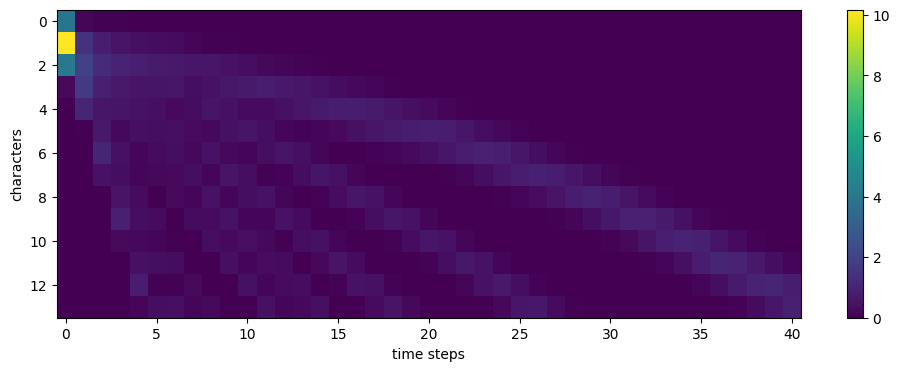

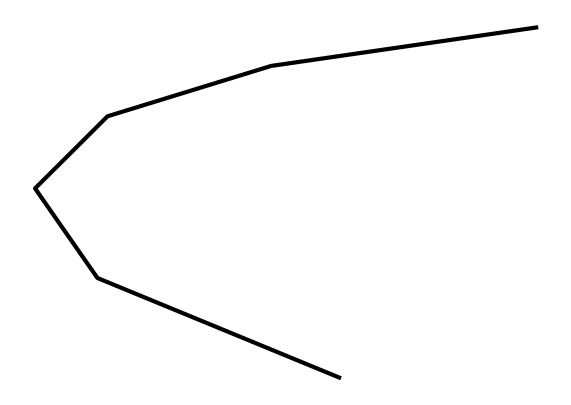


--- Epoch 2 ---


Training Epoch 2:   0%|          | 0/169 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: -211.3827 | Valid Loss: -254.5395
Saving best model at epoch 2
Vocab size:  77
Hello Colab!  
Generating sequence....
batch_size: 1
EOS: True
seq_len: 87
Input seq:  Hello Colab!  
Length of input sequence:  14


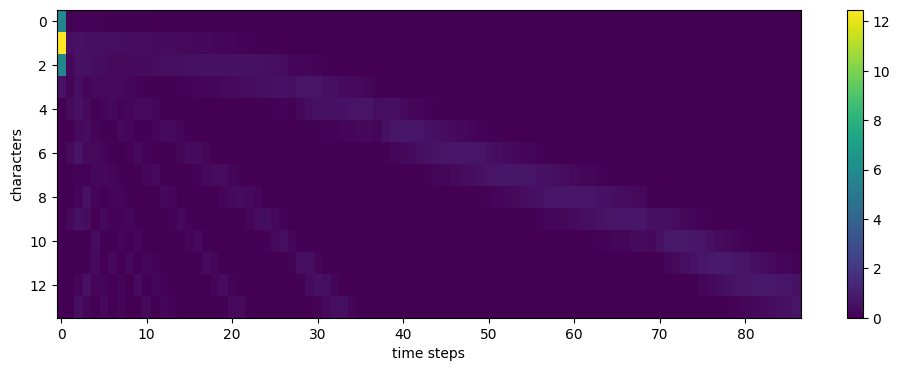

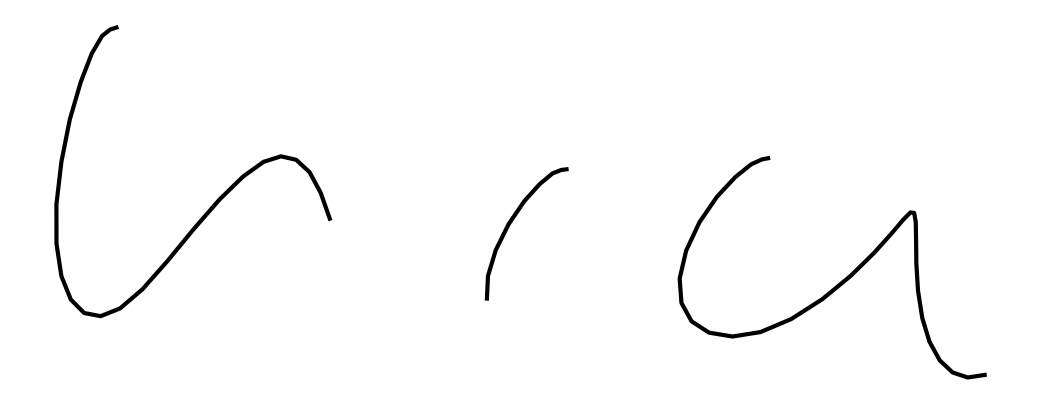


--- Epoch 3 ---


Training Epoch 3:   0%|          | 0/169 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: -297.5185 | Valid Loss: -303.1135
Saving best model at epoch 3
Vocab size:  77
Hello Colab!  
Generating sequence....
batch_size: 1
EOS: True
seq_len: 46
Input seq:  Hello Colab!  
Length of input sequence:  14


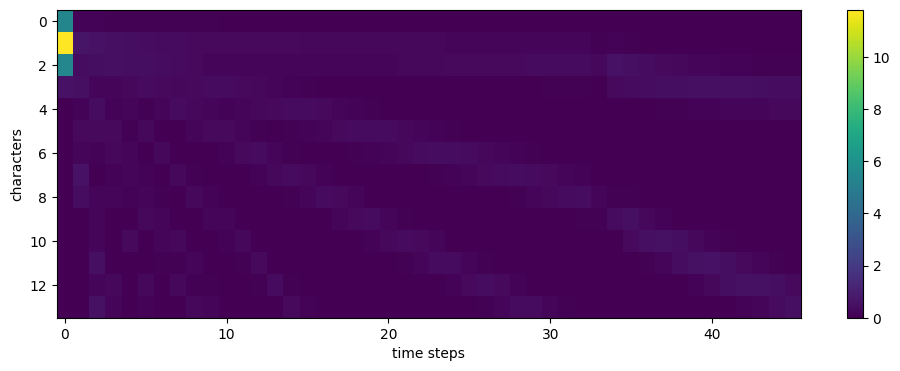

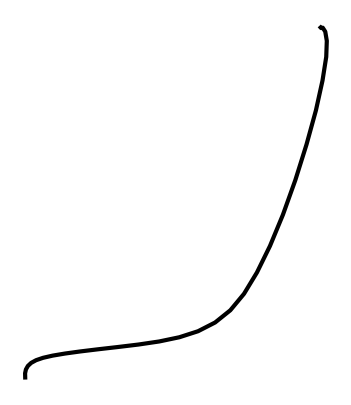


--- Epoch 4 ---


Training Epoch 4:   0%|          | 0/169 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: -347.2728 | Valid Loss: -357.6603
Saving best model at epoch 4
Vocab size:  77
Hello Colab!  
Generating sequence....
batch_size: 1
EOS: True
seq_len: 25
Input seq:  Hello Colab!  
Length of input sequence:  14


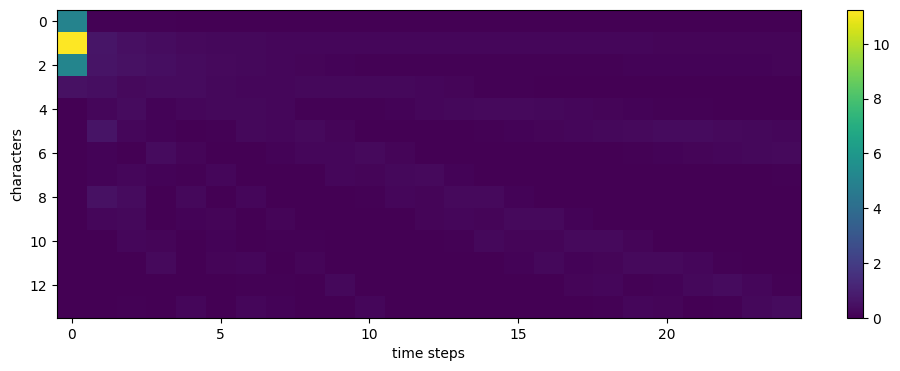

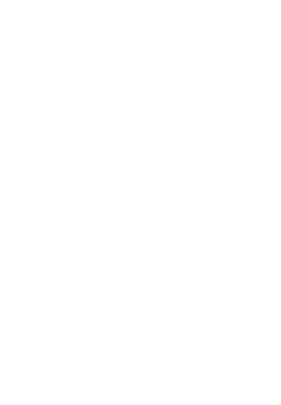


--- Epoch 5 ---


Training Epoch 5:   0%|          | 0/169 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: -379.6595 | Valid Loss: -384.7856
Saving best model at epoch 5
Vocab size:  77
Hello Colab!  
Generating sequence....
batch_size: 1
EOS: True
seq_len: 12
Input seq:  Hello Colab!  
Length of input sequence:  14


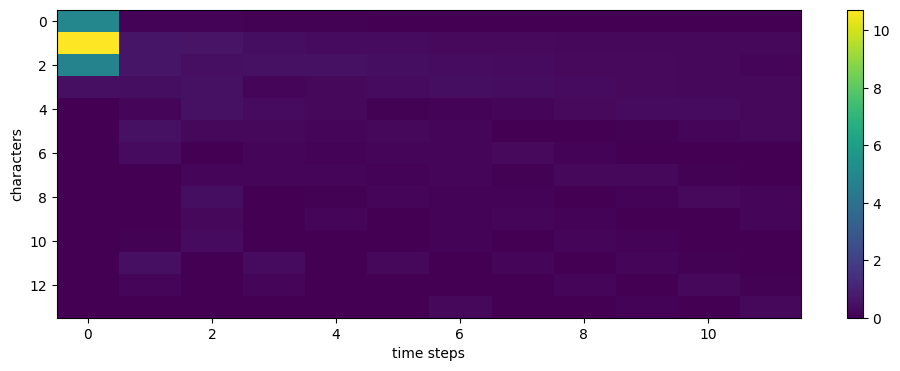

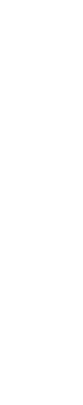


--- Epoch 6 ---


Training Epoch 6:   0%|          | 0/169 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: -400.2385 | Valid Loss: -409.6237
Saving best model at epoch 6
Vocab size:  77
Hello Colab!  
Generating sequence....
batch_size: 1
EOS: True
seq_len: 43
Input seq:  Hello Colab!  
Length of input sequence:  14


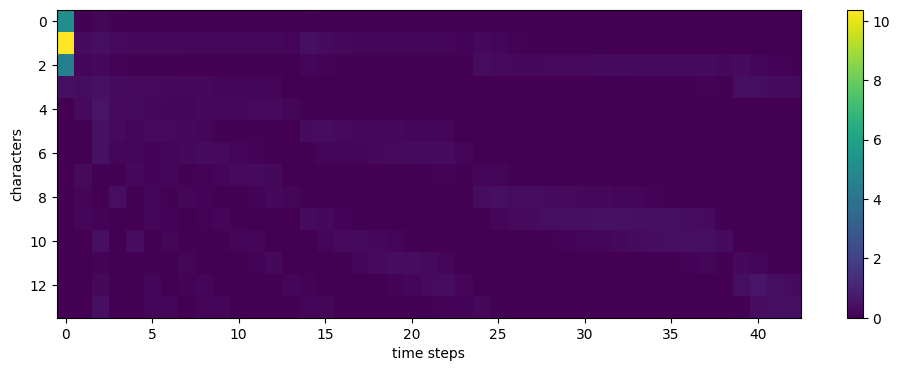

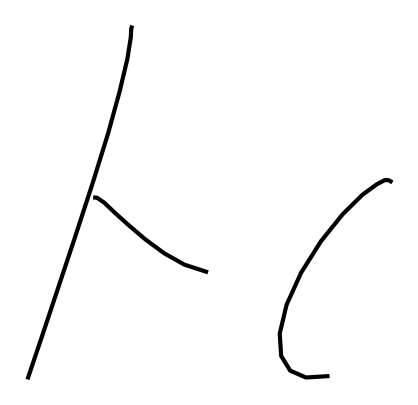


--- Epoch 7 ---


Training Epoch 7:   0%|          | 0/169 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: -426.4396 | Valid Loss: -427.2789
Saving best model at epoch 7
Vocab size:  77
Hello Colab!  
Generating sequence....
batch_size: 1
EOS: True
seq_len: 24
Input seq:  Hello Colab!  
Length of input sequence:  14


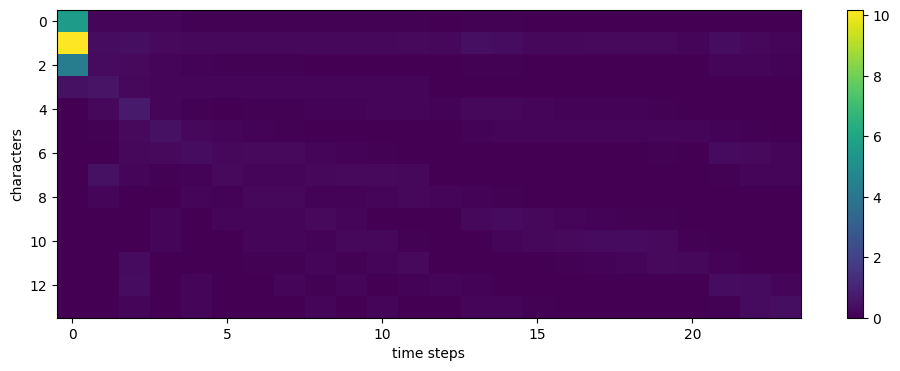

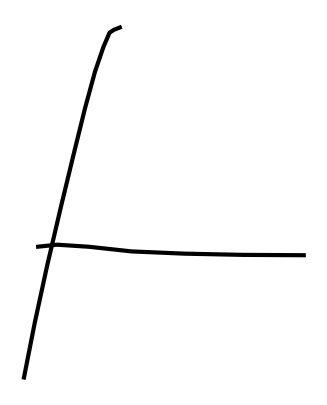


--- Epoch 8 ---


Training Epoch 8:   0%|          | 0/169 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: -446.6052 | Valid Loss: -452.8807
Saving best model at epoch 8
Vocab size:  77
Hello Colab!  
Generating sequence....
batch_size: 1
EOS: True
seq_len: 44
Input seq:  Hello Colab!  
Length of input sequence:  14


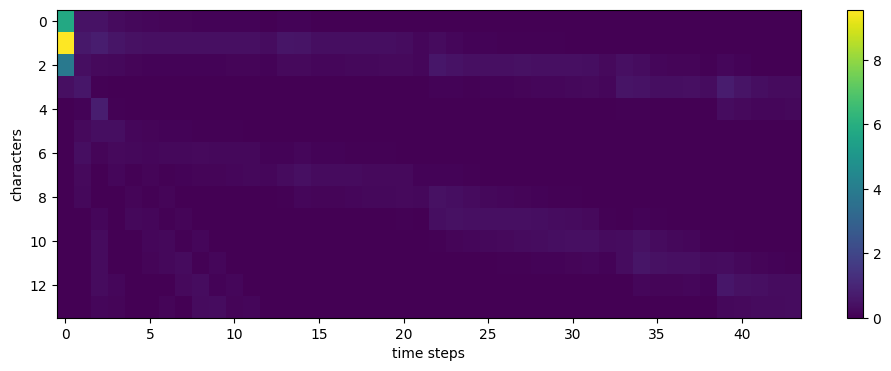

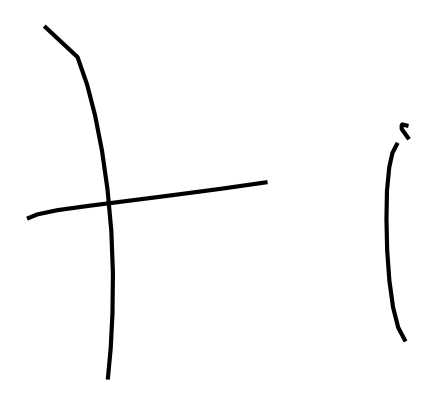


--- Epoch 9 ---


Training Epoch 9:   0%|          | 0/169 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: -460.5497 | Valid Loss: -454.2236
Saving best model at epoch 9
Vocab size:  77
Hello Colab!  
Generating sequence....
batch_size: 1
EOS: True
seq_len: 19
Input seq:  Hello Colab!  
Length of input sequence:  14


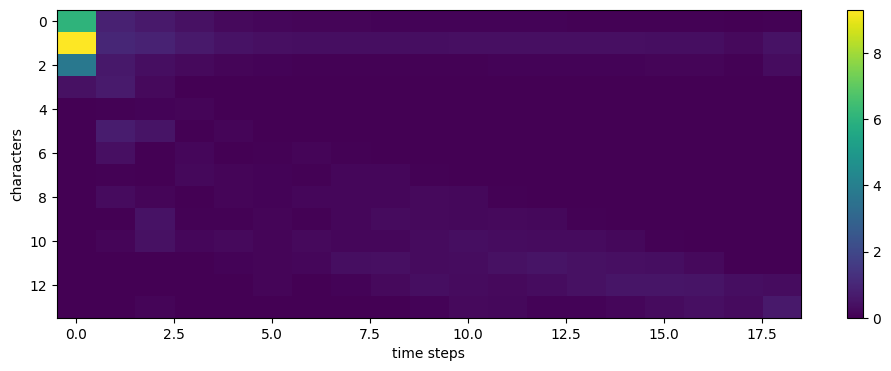

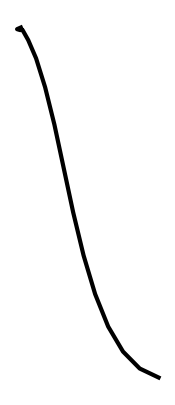


--- Epoch 10 ---


Training Epoch 10:   0%|          | 0/169 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: -474.8324 | Valid Loss: -466.4855
Saving best model at epoch 10
Vocab size:  77
Hello Colab!  
Generating sequence....
batch_size: 1
EOS: True
seq_len: 22
Input seq:  Hello Colab!  
Length of input sequence:  14


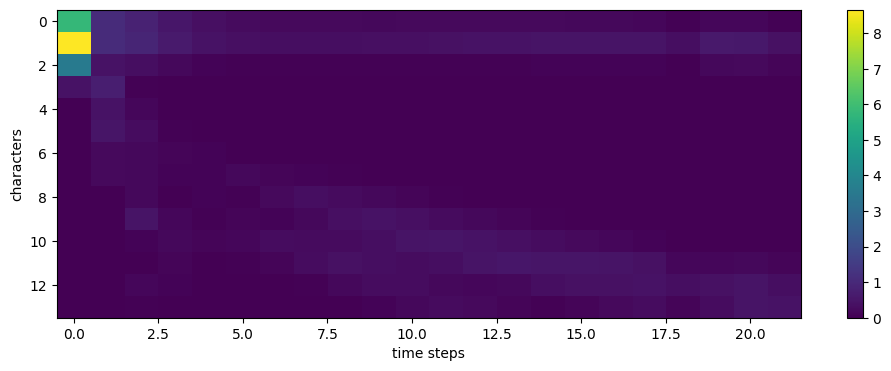

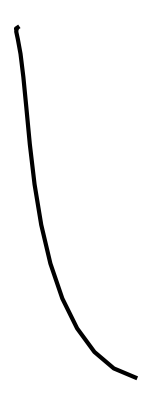


--- Epoch 11 ---


Training Epoch 11:   0%|          | 0/169 [00:00<?, ?it/s]

Validation Epoch 11:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: -486.1051 | Valid Loss: -493.0212
Saving best model at epoch 11
Vocab size:  77
Hello Colab!  
Generating sequence....
batch_size: 1
EOS: True
seq_len: 34
Input seq:  Hello Colab!  
Length of input sequence:  14


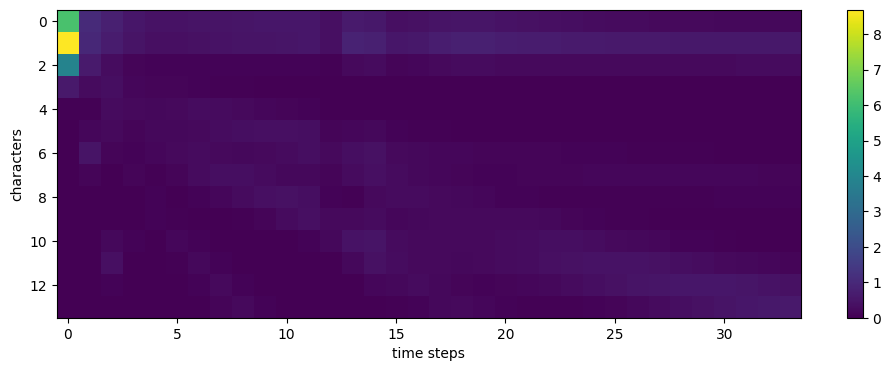

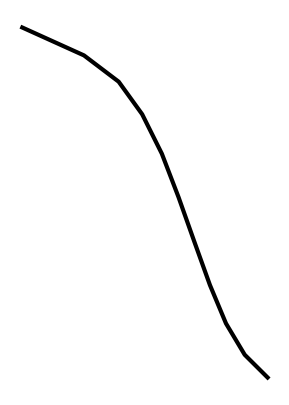


--- Epoch 12 ---


Training Epoch 12:   0%|          | 0/169 [00:00<?, ?it/s]

Validation Epoch 12:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: -509.6570 | Valid Loss: -511.0985
Saving best model at epoch 12
Vocab size:  77
Hello Colab!  
Generating sequence....
batch_size: 1
EOS: True
seq_len: 140
Input seq:  Hello Colab!  
Length of input sequence:  14


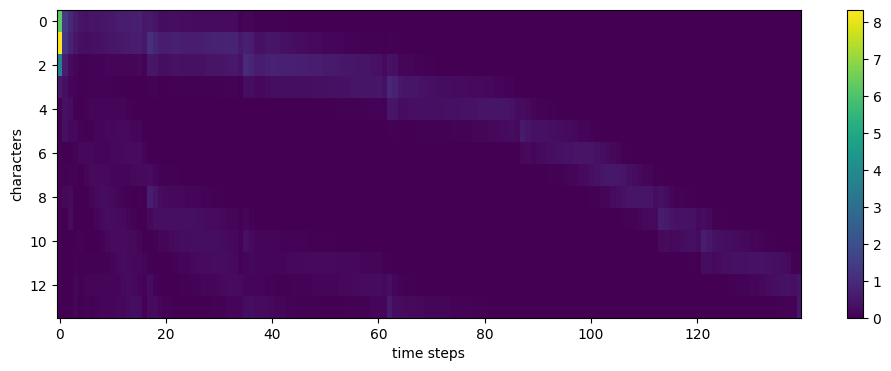

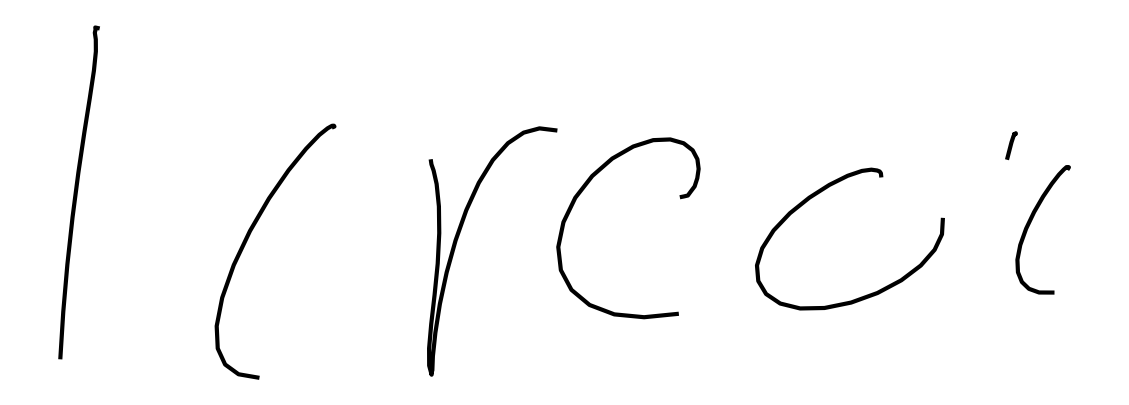


--- Epoch 13 ---


Training Epoch 13:   0%|          | 0/169 [00:00<?, ?it/s]

In [ ]:

def train_epoch(model, optimizer, epoch, train_loader, device):
    model.train()
    avg_loss = 0.0

    for mini_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        inputs, targets, mask, text, text_mask = mini_batch
        inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)
        text, text_mask = text.to(device), text_mask.to(device)

        batch_size = inputs.shape[0]
        optimizer.zero_grad()

        initial_hidden, window_vector, kappa = model.init_hidden(batch_size, device)
        y_hat, state, window_vector, kappa = model.forward(
            inputs, text, text_mask, initial_hidden, window_vector, kappa
        )

        loss = compute_nll_loss(targets, y_hat, mask)
        y_hat.register_hook(lambda grad: torch.clamp(grad, -100, 100))
        loss.backward()

        nn.utils.clip_grad_value_(model.lstm_1.parameters(), 10)
        nn.utils.clip_grad_value_(model.lstm_2.parameters(), 10)
        nn.utils.clip_grad_value_(model.lstm_3.parameters(), 10)
        nn.utils.clip_grad_value_(model.window_layer.parameters(), 10)

        optimizer.step()
        avg_loss += loss.item()

    avg_loss /= len(train_loader.dataset)
    return avg_loss


def validation(model, valid_loader, device, epoch):
    model.eval()
    avg_loss = 0.0

    with torch.no_grad():
        for mini_batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}"):
            inputs, targets, mask, text, text_mask = mini_batch
            inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)
            text, text_mask = text.to(device), text_mask.to(device)

            batch_size = inputs.shape[0]
            initial_hidden, window_vector, kappa = model.init_hidden(batch_size, device)
            y_hat, state, window_vector, kappa = model.forward(
                inputs, text, text_mask, initial_hidden, window_vector, kappa
            )

            loss = compute_nll_loss(targets, y_hat, mask)
            avg_loss += loss.item()

    avg_loss /= len(valid_loader.dataset)
    return avg_loss


def train(model, train_loader, valid_loader, batch_size, n_epochs, lr, patience, step_size, device, save_path):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)

    best_loss = math.inf
    best_epoch = 0
    k = 0

    model_path = os.path.join(save_path, "best_model_synthesis.pt")

    for epoch in range(n_epochs):
        print(f"\n--- Epoch {epoch+1} ---")
        train_loss = train_epoch(model, optimizer, epoch, train_loader, device)
        valid_loss = validation(model, valid_loader, device, epoch)

        print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")
        scheduler.step()

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch + 1
            print(f"Saving best model at epoch {best_epoch}")
            torch.save(model.state_dict(), model_path)

            # Generate a sample sequence
            gen_seq, phi = generate_conditional_sequence(
                model_path,
                "Hello Colab!",
                device,
                train_loader.dataset.char_to_id,
                train_loader.dataset.idx_to_char,
                bias=10.0,
                prime=False,
                prime_seq=None,
                real_text=None,
                is_map=True,
            )

            # Plot attention heatmap inline
            plt.figure(figsize=(12,4))
            plt.imshow(phi, cmap="viridis", aspect="auto")
            plt.colorbar()
            plt.xlabel("time steps")
            plt.ylabel("characters")
            plt.show()

            # Denormalize and plot strokes
            gen_seq = data_denormalization(Global.train_mean, Global.train_std, gen_seq)
            plot_stroke(gen_seq[0])  # inline plotting
            k = 0
        elif k > patience:
            print(f"Early stopping. Best epoch: {best_epoch}")
            break
        else:
            k += 1


train(
    model,
    train_loader,
    valid_loader,
    batch_size,
    n_epochs,
    lr,
    patience,
    step_size,
    device,
    save_path
)
